# Ways to Deal with Time Series Forecasting

This notebook helps you to get more in the details to manipulate data with Python and Jupyter.

## About the dataset & notebook

Description of context is coming later...

- [ ] [Input Data](https://www.kaggle.com/code/mfaaris/3-ways-to-deal-with-time-series-forecasting/input).
- [ ] [Hourly Energy Consumption, Time Series Analysis](https://www.kaggle.com/code/mfaaris/3-ways-to-deal-with-time-series-forecasting/input).

# Table of Contents

In this notebook, we will cover:
* [Overview](#0)
* [Importing Libraries](#1)
* [Loading Dataset](#2)
* [Data Transformation](#3)
* [Building Models](#4)
    1. [Prophet](#5)
    2. [XGBoost](#6)
    3. [Deep Neural Network](#7)
* [Conclusion](#8)

TO-DO NEXT:
- [ ] Problem with notebook links. They do not target at the right position.

<a id="0"></a>
# Overview

PJM Interconnection LCC is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

This dataset contains over 10 years of hourly energy consumption data from PJM in Megawatts (MW).

The following tutorial & notebook will go through the model solution for univariate time series. There are endless models out there when it comes to time series, one of the most popular methods is Prophet developed by Facebook/Meta.

We will go through different approaches to become familiar with such datasets and get insights from it.

Further techniques will be also presented (but they are out of the course's background).

<a id="1"></a>
<a id='section_idlib'></a>
# Importing Libraries

There are two ways to install [prophet](https://facebook.github.io/prophet/docs/installation.html):
1. `mamba install -c conda-forge prophet`
2. `pip install prophet`

In [1]:
# Data processing
import numpy as np
import pandas as pd
import copy
from copy import deepcopy
import multiprocessing
import datetime
from datetime import timedelta, datetime
from pandas.tseries.offsets import DateOffset

# Pathways
from pathlib import Path
import pandas as pd
import urllib.request

# Plotting
import matplotlib
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mc
%matplotlib inline
import colorsys
#import calmap
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

# Enable grids on all plots and setting up a nice configuration
plt.rc('figure', figsize=(16, 10))
plt.rc('font', family='monospace', weight='bold', size=11)
plt.rc('axes', labelsize=11, titlesize=14)
plt.rc('legend', fontsize=11)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 2

# Statistics & modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

# Machine & deep learning
# import tensorflow as tf
# from prophet import Prophet
# from xgboost import XGBRegressor

TO-DO NEXT:
- [ ] `plt.rc('font', family='monospace', weight='bold', size=11)` seems not working for the `weight='bold'` parameter.

## Generating utility functions

### Functions for Matplotlib figures

In [2]:
# Extra code – code to save the figures as high-res PNGs for the book
IMAGES_PATH = Path() / "img"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig_png(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """This function saves a figure to a file in the IMAGES_PATH directory.

    Args:
        fig_id (_type_): this parameter identifies and saves in the format specified by `fig_extension` parameter.
        tight_layout (bool, optional): this parameter will make sure the function will adjust the subplot parameters to give specified padding. Defaults to True.
        fig_extension (str, optional): _description_. Defaults to "png".
        resolution (int, optional): this parameter specifies the resolution of the saved inmage in dots per inch. Defaults to 300.
    """
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_fig_eps(fig_id, tight_layout=True, fig_extension="eps"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension)

### Functions for plotly figures

In [3]:
def save_plotly_html(fig_id, fig_extension="html"):
    """This function saves an html figure to a file in the IMAGES_PATH directory.

    Args:
        
    """   
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    fig.write_html(path)

**Note**: `write_html` and `plotly.offline.plot` with html option are both used to save Plotly figures as HTML files. 
The difference between them is that `write_html` writes the figure to an HTML file on disk while `plotly.offline.plot` opens the figure in a web browser.

<a id="2"></a>
# Loading Dataset

For this tutorial, we will use just three [datasets](https://www.kaggle.com/code/mfaaris/3-ways-to-deal-with-time-series-forecasting/input) to get an idea of what it looks like, as the approach will be the same for all of them.

Description is coming later...

In [4]:
folder_name = r"./.cache/"

df1 = pd.read_csv(folder_name + "hourly-energy-consumption/AEP_hourly.csv", index_col='Datetime')
df2 = pd.read_csv(folder_name + "hourly-energy-consumption/COMED_hourly.csv", index_col='Datetime')
df3 = pd.read_csv(folder_name + "hourly-energy-consumption/DAYTON_hourly.csv", index_col='Datetime')
df4 = pd.read_csv(folder_name + "hourly-energy-consumption/DEOK_hourly.csv", index_col='Datetime')
df5 = pd.read_csv(folder_name + "hourly-energy-consumption/DOM_hourly.csv", index_col='Datetime')
df6 = pd.read_csv(folder_name + "hourly-energy-consumption/DUQ_hourly.csv", index_col='Datetime')
df7 = pd.read_csv(folder_name + "hourly-energy-consumption/EKPC_hourly.csv", index_col='Datetime')
df8 = pd.read_csv(folder_name + "hourly-energy-consumption/FE_hourly.csv", index_col='Datetime')
df9 = pd.read_csv(folder_name + "hourly-energy-consumption/NI_hourly.csv", index_col='Datetime')
df10 = pd.read_csv(folder_name + "hourly-energy-consumption/PJME_hourly.csv", index_col='Datetime')
df11 = pd.read_csv(folder_name + "hourly-energy-consumption/PJMW_hourly.csv", index_col='Datetime')

# For visualization purpose
df_final = df1.join([df2, df3, df4, df5, df6, df7, df8, df9, df10, df11])

# We only use DAYTON_hourly.csv for modeling later since the approach is the same for each file
df = df3
df.head()


FileNotFoundError: [Errno 2] No such file or directory: './.cache/hourly-energy-consumption/AEP_hourly.csv'

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125361 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     125361 non-null  float64
 1   COMED_MW   70583 non-null   float64
 2   DAYTON_MW  125361 non-null  float64
 3   DEOK_MW    61825 non-null   float64
 4   DOM_MW     120275 non-null  float64
 5   DUQ_MW     123154 non-null  float64
 6   EKPC_MW    49421 non-null   float64
 7   FE_MW      66960 non-null   float64
 8   NI_MW      54778 non-null   float64
 9   PJME_MW    125361 non-null  float64
 10  PJMW_MW    125361 non-null  float64
dtypes: float64(11)
memory usage: 11.5+ MB


In [ ]:
df_final.describe()

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW
count,125361.000000,70583.000000,125361.000000,61825.000000,120275.000000,123154.000000,49421.000000,66960.000000,54778.000000,125361.000000,125361.000000
mean,15363.077847,11237.756174,2017.668996,3041.597541,10845.028119,1642.043401,1435.357722,7663.627688,11713.761236,31759.038983,5531.513541
std,2661.589281,2357.022834,402.920846,637.299488,2438.253016,310.399093,382.815695,1386.468697,2363.414180,6643.720256,1008.678744
min,9581.000000,7237.000000,982.000000,907.000000,1253.000000,1014.000000,514.000000,0.000000,7003.000000,14544.000000,2553.000000
25%,13416.000000,9496.000000,1716.000000,2594.000000,9154.000000,1423.000000,1153.000000,6608.000000,9981.000000,27103.000000,4788.000000
50%,15206.000000,11018.000000,1994.000000,2971.000000,10402.000000,1618.000000,1365.000000,7606.000000,11530.000000,31182.000000,5447.000000
75%,17121.000000,12397.000000,2267.000000,3409.000000,12287.500000,1811.000000,1667.000000,8483.000000,12891.000000,35451.000000,6199.000000
max,25695.000000,23753.000000,3746.000000,5445.000000,21651.000000,3054.000000,3490.000000,14032.000000,23631.000000,62009.000000,9594.000000


In [ ]:
df_final.tail(20)

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW
Datetime,,,,,,,,,,,
2018-08-02 05:00:00,12224.0,9931.0,1604.0,2613.0,10058.0,1353.0,1070.0,6407.0,NaN,29854.0,4594.0
2018-08-02 06:00:00,12781.0,9996.0,1684.0,2728.0,10490.0,1413.0,1156.0,6754.0,NaN,31197.0,4826.0
2018-08-02 07:00:00,13661.0,10482.0,1820.0,2956.0,11181.0,1503.0,1204.0,7234.0,NaN,33182.0,5114.0
2018-08-02 08:00:00,14326.0,11200.0,1927.0,3083.0,11850.0,1592.0,1276.0,7594.0,NaN,35645.0,5333.0
2018-08-02 09:00:00,14834.0,12179.0,2023.0,3239.0,12555.0,1674.0,1319.0,7927.0,NaN,37810.0,5597.0
2018-08-02 10:00:00,15309.0,13042.0,2107.0,3359.0,13232.0,1735.0,1356.0,8231.0,NaN,39902.0,5775.0
2018-08-02 11:00:00,16025.0,13828.0,2226.0,3536.0,13966.0,1792.0,1463.0,8673.0,NaN,42189.0,6050.0
2018-08-02 12:00:00,16651.0,14790.0,2315.0,3674.0,14666.0,1865.0,1520.0,9242.0,NaN,43954.0,6152.0
2018-08-02 13:00:00,17423.0,15527.0,2429.0,3890.0,15191.0,1931.0,1635.0,9639.0,NaN,45372.0,6299.0


<a id="3"></a>
# Data Transformation

## Plot the data

First method to plot with pandas in the simplest way but less manageable:

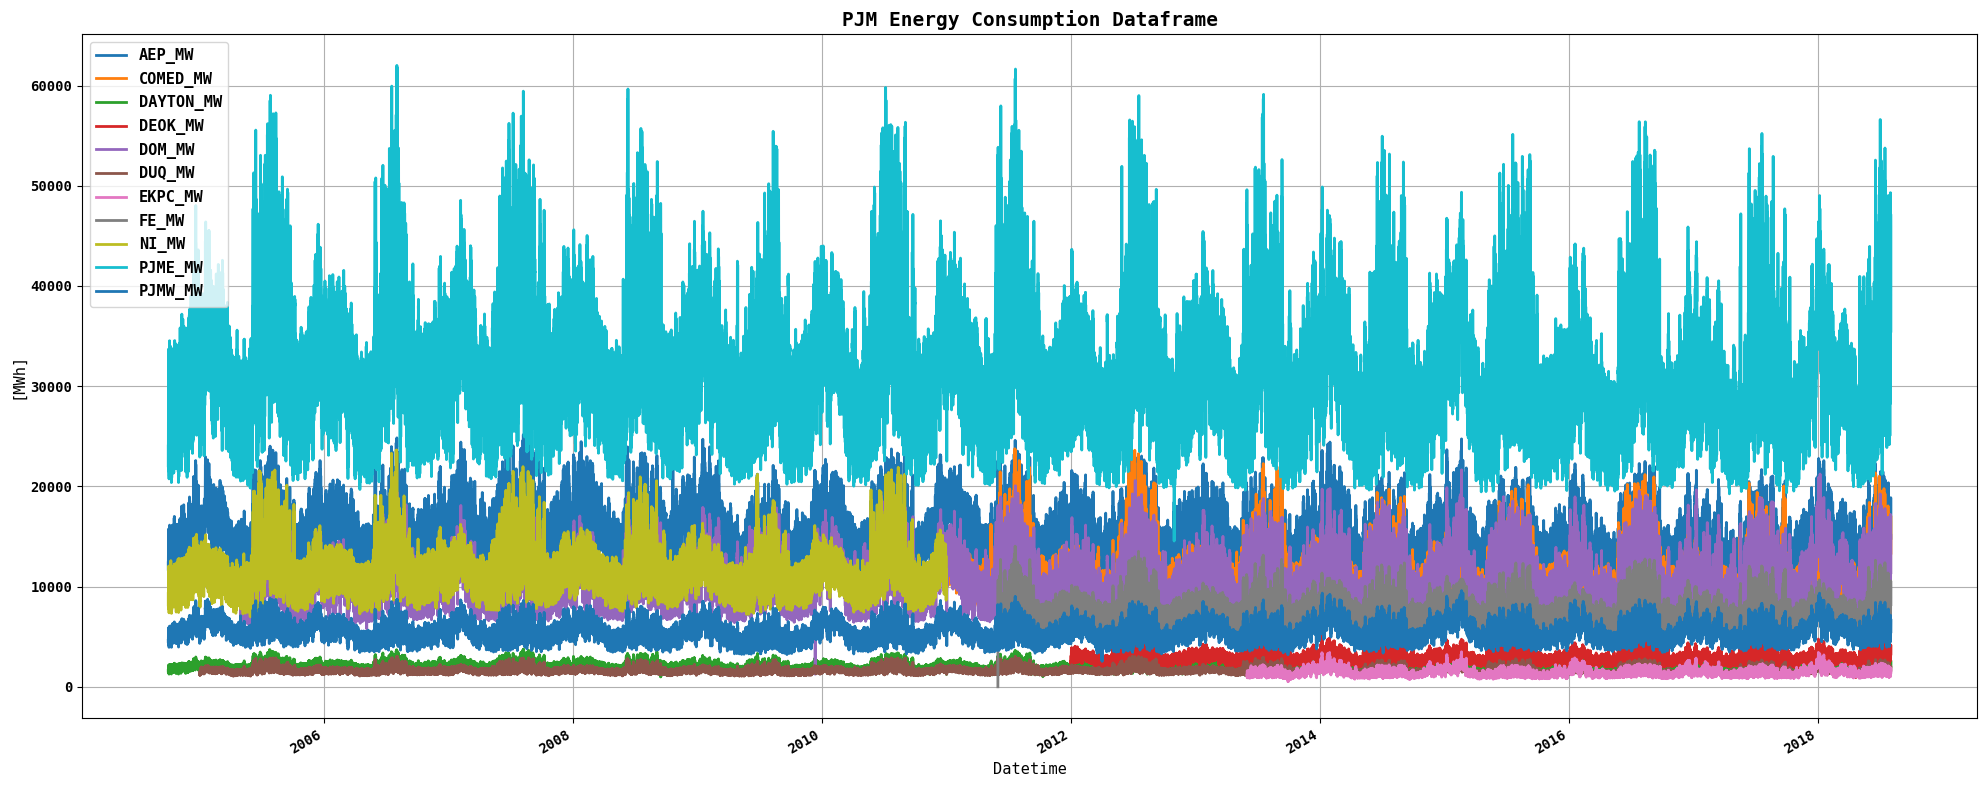

In [ ]:
df_final.index = pd.to_datetime(df_final.index)
df_final.plot(figsize=(20,8))
plt.title('PJM Energy Consumption Dataframe', weight='bold')
plt.ylabel('[MWh]')
plt.legend(loc='best')

save_fig_png("01_energy_consumption_df_pandas")

Second method with Matplotlib:

/tmp/ipykernel_22684/2438665973.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


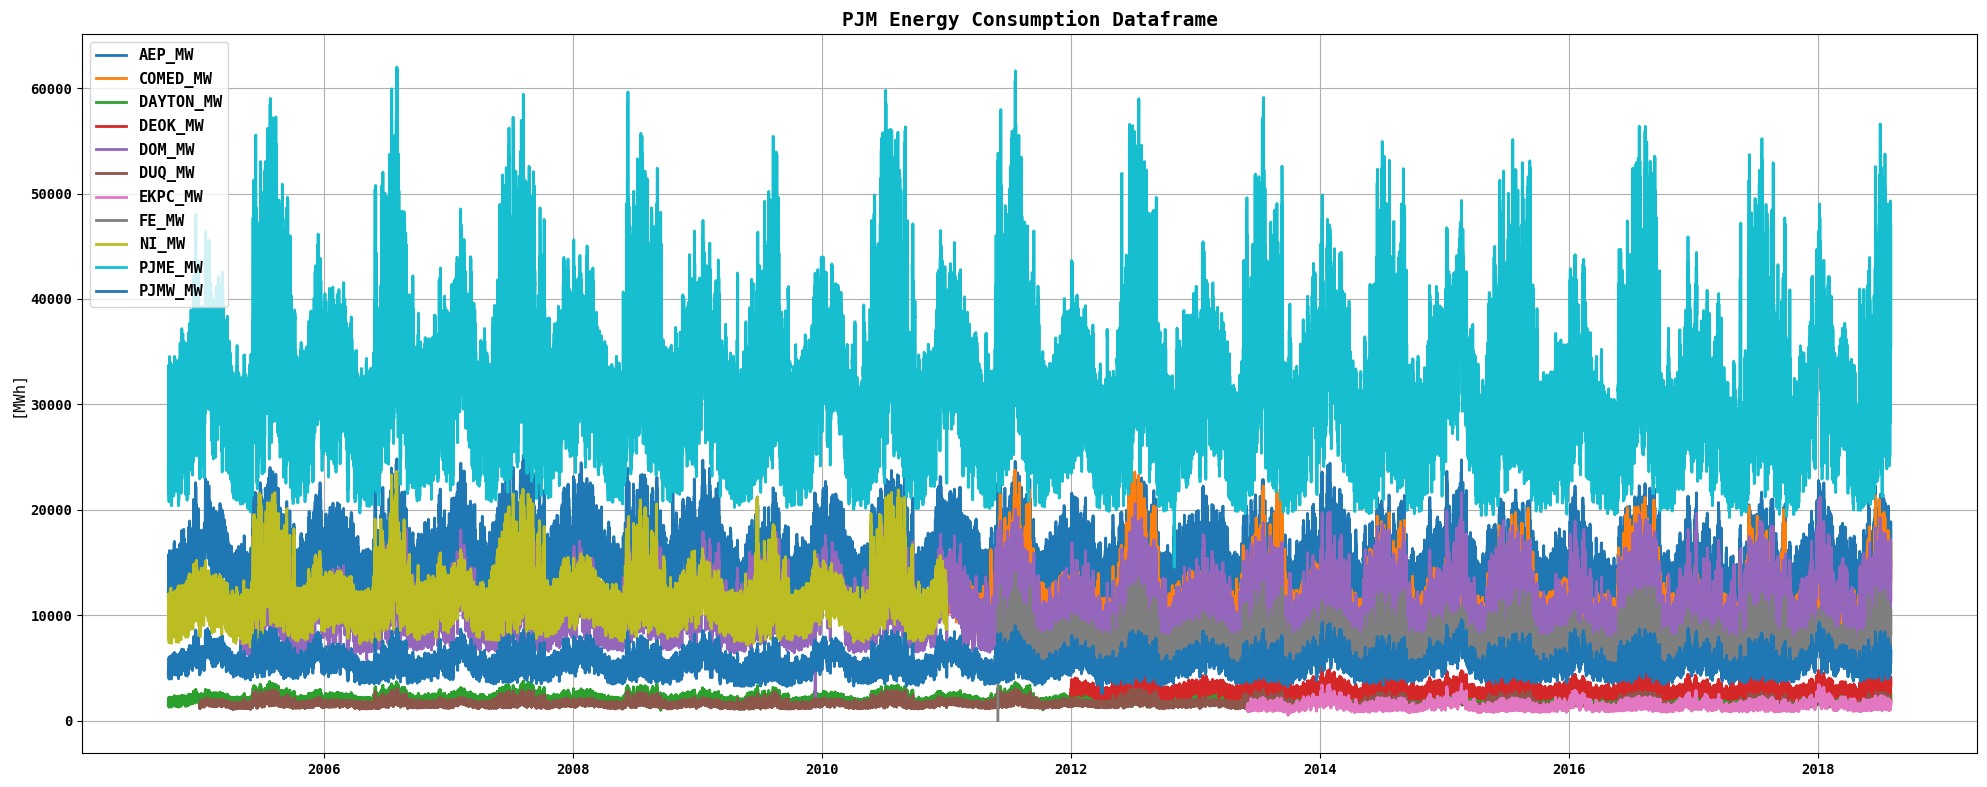

In [ ]:
# Create figure 
fig, axs = plt.subplots(layout='constrained', sharex=True, figsize=(20, 8))

for i, column in enumerate(df_final.columns):
    axs.plot(df_final.index, df_final[column], label=column)

plt.title("PJM Energy Consumption Dataframe", weight='bold')
plt.ylabel('[MWh]')
plt.grid(True)
plt.legend(loc='best')

save_fig_png("01b_energy_consumption_df_matplotlib")

Third method with plotly express:

In [ ]:
import plotly.express as px

fig = px.line(df_final, width=1600 , height=1000)

fig.update_layout(title="PJM Energy Consumption Dataframe", xaxis_title="Date", yaxis_title="[MWh]", legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

save_plotly_html("01c_energy_consumption_df_plotly1")
# fig.show()

**Note**: Plotly Express is a built-in part of the plotly library and is the recommended starting point for creating most common figures. Every Plotly Express function uses graph objects internally and returns a `plotly.graph_objects.Figure` instance. The `plotly.graph_objs` module (typically imported as `go`) contains an automatically-generated hierarchy of Python classes which represent non-leaf nodes in the figure schema. The term "graph objects" refers to instances of these classes. In summary, Plotly Express is a high-level interface for creating figures with `plotly.graph_objs` under the hood.

Fourth method with plotly objects:

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()

for i, column in enumerate(df_final.columns):
    fig.add_trace(go.Scatter(x=df_final.index, y=df_final[column], name=column))

fig.update_layout(title="PJM Energy Consumption Dataframe", xaxis_title="Date", yaxis_title="[MWh]", 
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01), width=1600 , height=1000)

save_plotly_html("01d_energy_consumption_df_plotly2")
# fig.show()

**Note**: As you can see, the plotly library makes it easier to visualise output curves. However, it is a little more complex to set up. In this course, we will continue to use Matplotlib and pandas to plot our dataframes. Simply because by starting with Python, coming from the MATLAB world, the transfer of knowledge is better.

## Selecting a specific range 

As we can observe, this is not an acceptable plot to be analyzed correctly. However, we can see at the first glance that PJME has the highest energy consumption among the rest of consumers. Also the datetime of some column of this dataframe aren't the same. Like `NI`, `EKPC`, and `DEOK`.

Let's narrow it down to the first week of 2018 to see the graph more clearly:

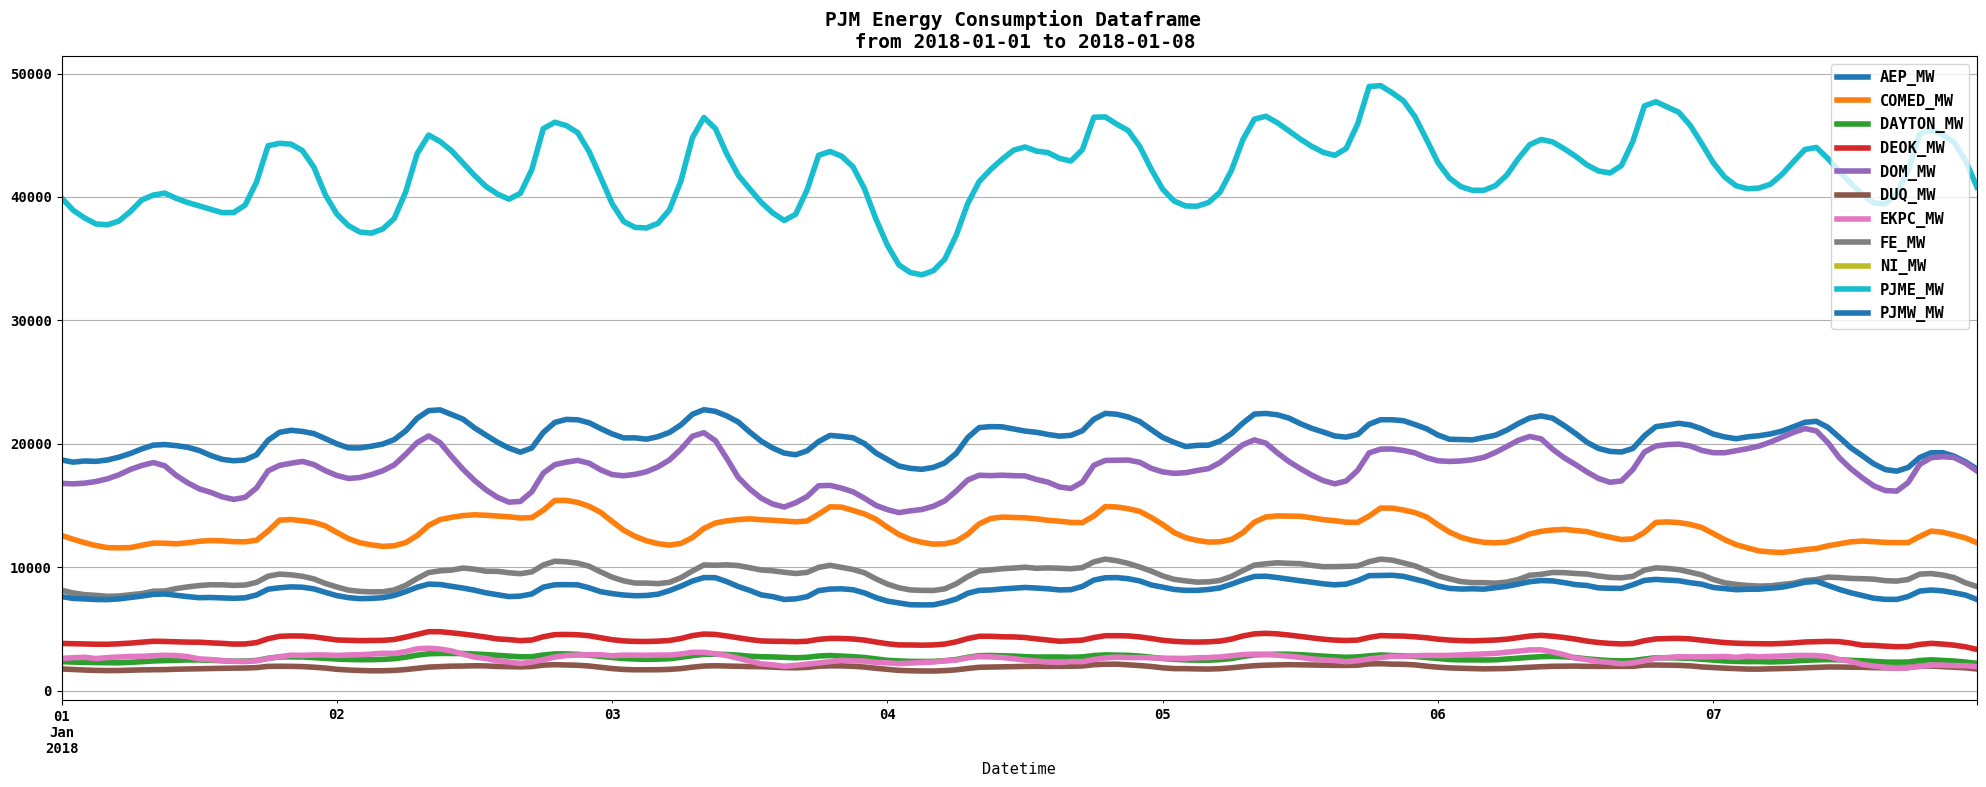

In [ ]:
df_2018 = df_final[(df_final.index >= '2018-01-01') & (df_final.index < '2018-01-08')]

df_2018.plot(figsize=(20,8), lw=4) # `lw` stands for line width. It is used to specify the width of lines in plots.
plt.title('PJM Energy Consumption Dataframe \n from 2018-01-01 to 2018-01-08', weight='bold')

save_fig_png("02_energy_consumption_df_2018")

In the code above, we could change the title size with the additional parameters passed into `plt.title()`, as follows:

```python
plt.title('PJM Energy Consumption\nfrom 2018-01-01 to 2018-01-08', weight='bold', fontsize=25)
```

However, we already defined the size and the type of font in this part of the [notebook](#section_idlib), we didn't use it.

To select some part of the datetime index we can use `.index.hour` to select only the hour of the Datetime object:

In [ ]:
df_final.index.hour

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
      dtype='int32', name='Datetime', length=125361)

If you want more information about [dtypes](https://pandas.pydata.org/docs/user_guide/basics.html#dtypes), the pandas documentation is well written.
In a nutshell, pandas uses NumPy arrays and dtypes for Series or individual columns of a DataFrame. The most important dtypes are the following:
- `float`
- `int`
- `bool`
- `timedelta64[ns]`
- `datetime64[ns]`

**Note**: NumPy does not support timezone-aware datetimes.

We are going to create new columns in a DataFrame called `df_final` based on the index of the DataFrame:

In [ ]:
df_final['Hour'] = df_final.index.hour
df_final['Day'] = df_final.index.day
df_final['Month'] = df_final.index.month
df_final['Quarter'] = df_final.index.quarter
df_final['Year'] = df_final.index.year

df_final.head(3)

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW,Hour,Day,Month,Quarter,Year
Datetime,,,,,,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,NaN,1621.0,NaN,NaN,NaN,NaN,NaN,9305.0,24025.0,4628.0,1,1,10,4,2004
2004-10-01 02:00:00,11935.0,NaN,1536.0,NaN,NaN,NaN,NaN,NaN,8681.0,22845.0,4520.0,2,1,10,4,2004
2004-10-01 03:00:00,11692.0,NaN,1500.0,NaN,NaN,NaN,NaN,NaN,8314.0,22138.0,4431.0,3,1,10,4,2004


The new columns will `Hour`, `Day`, `Month`, `Quarter`. Each of these columns is being populated with the corresponding attribute of the index.
The last line displays the first 3 rows of the resulting DataFrame.

## Seaborn statistic plots

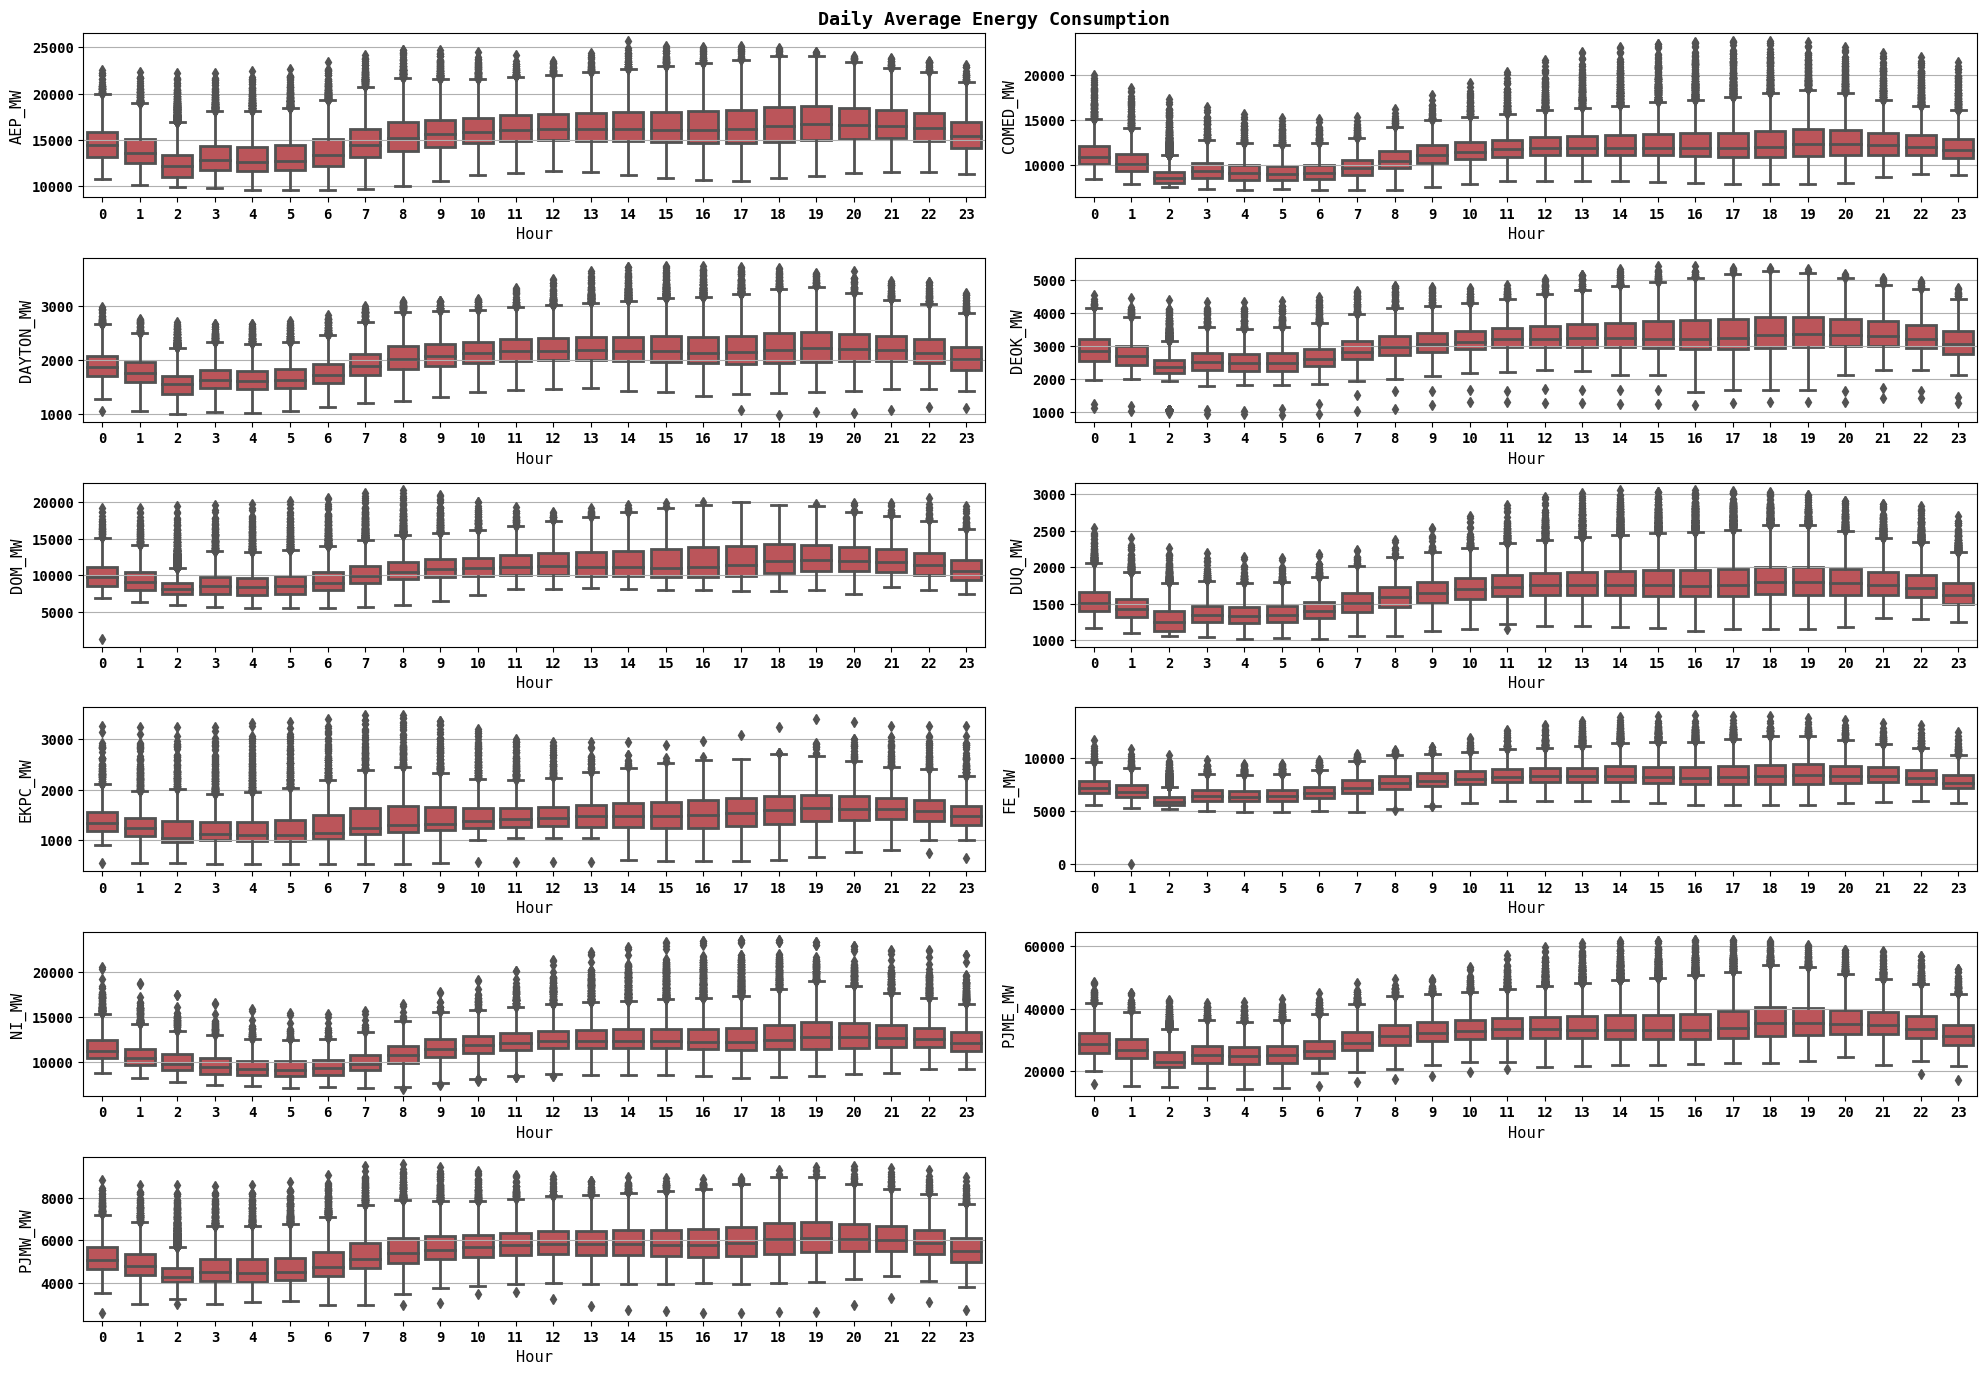

In [ ]:
columns = ['AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW', 'DUQ_MW',
           'EKPC_MW', 'FE_MW', 'NI_MW', 'PJME_MW', 'PJMW_MW']

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
fig.suptitle('Daily Average Energy Consumption', weight='bold')

# Only 11 figures are necessary, so we delete the last one
fig.delaxes(axs[5][1])

# We now use the seaborn package to plot the boxplots
for i, col in enumerate(columns):
    sns.boxplot(data=df_final, x='Hour', y=col, ax=axs.flatten()[i], color='#cc444b')

save_fig_png("03_energy_daily_boxplot_df_seaborn")

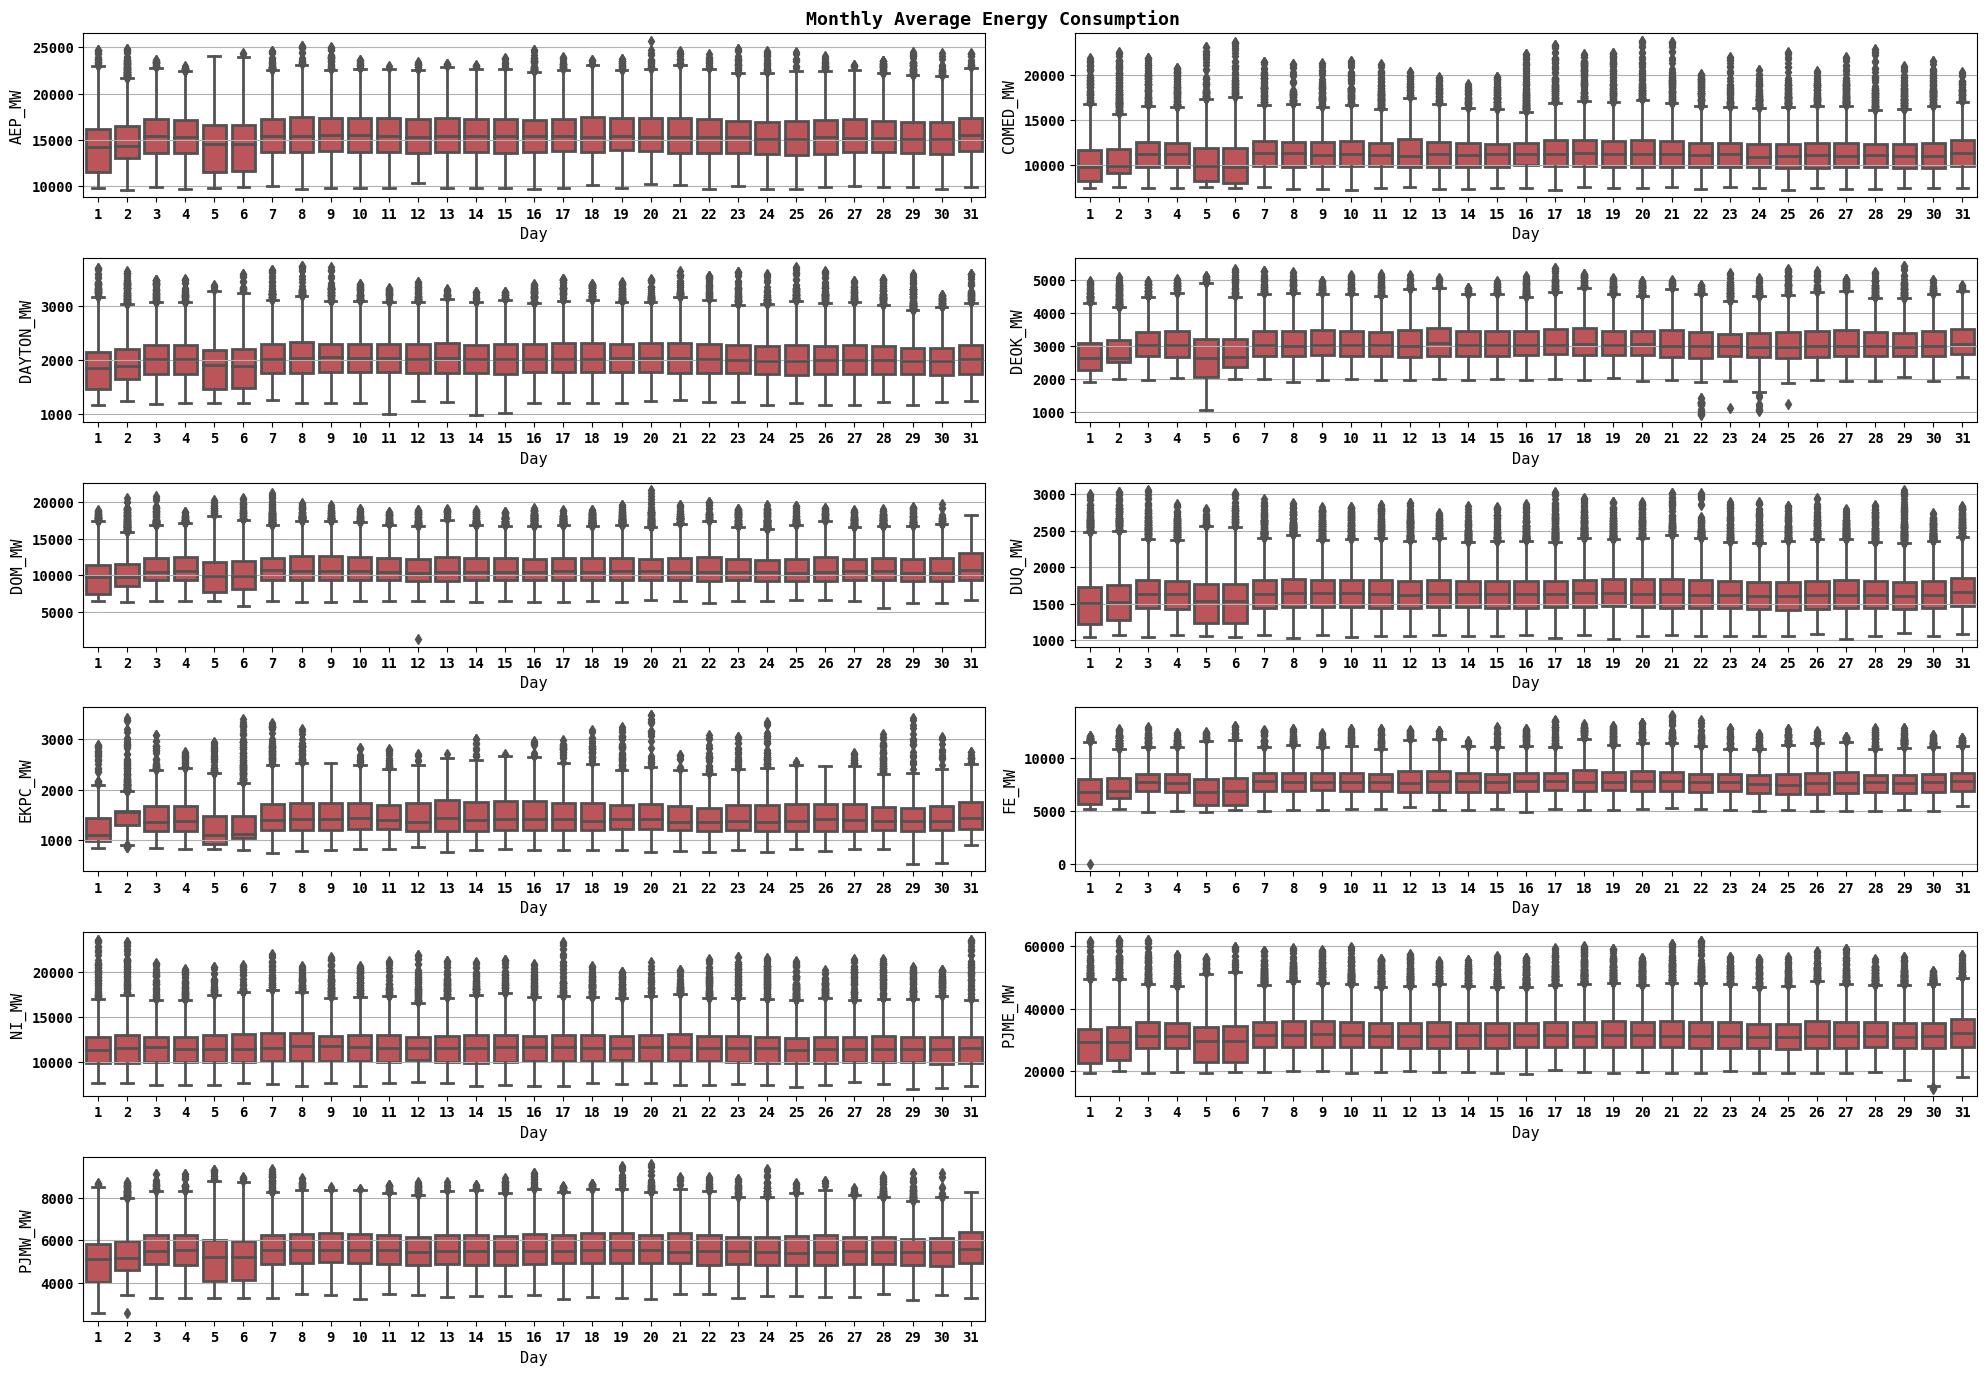

In [ ]:
# columns = ['AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW', 'DUQ_MW',
#            'EKPC_MW', 'FE_MW', 'NI_MW', 'PJME_MW', 'PJMW_MW']

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
fig.suptitle('Monthly Average Energy Consumption', weight='bold')

# Only 11 figures are necessary, so we delete the last one
fig.delaxes(axs[5][1])

# We now use the seaborn package to plot the boxplots
for i, col in enumerate(columns):
    sns.boxplot(data=df_final, x='Day', y=col, ax=axs.flatten()[i], color='#cc444b')

save_fig_png("04_energy_monthly_boxplot_df_seaborn")

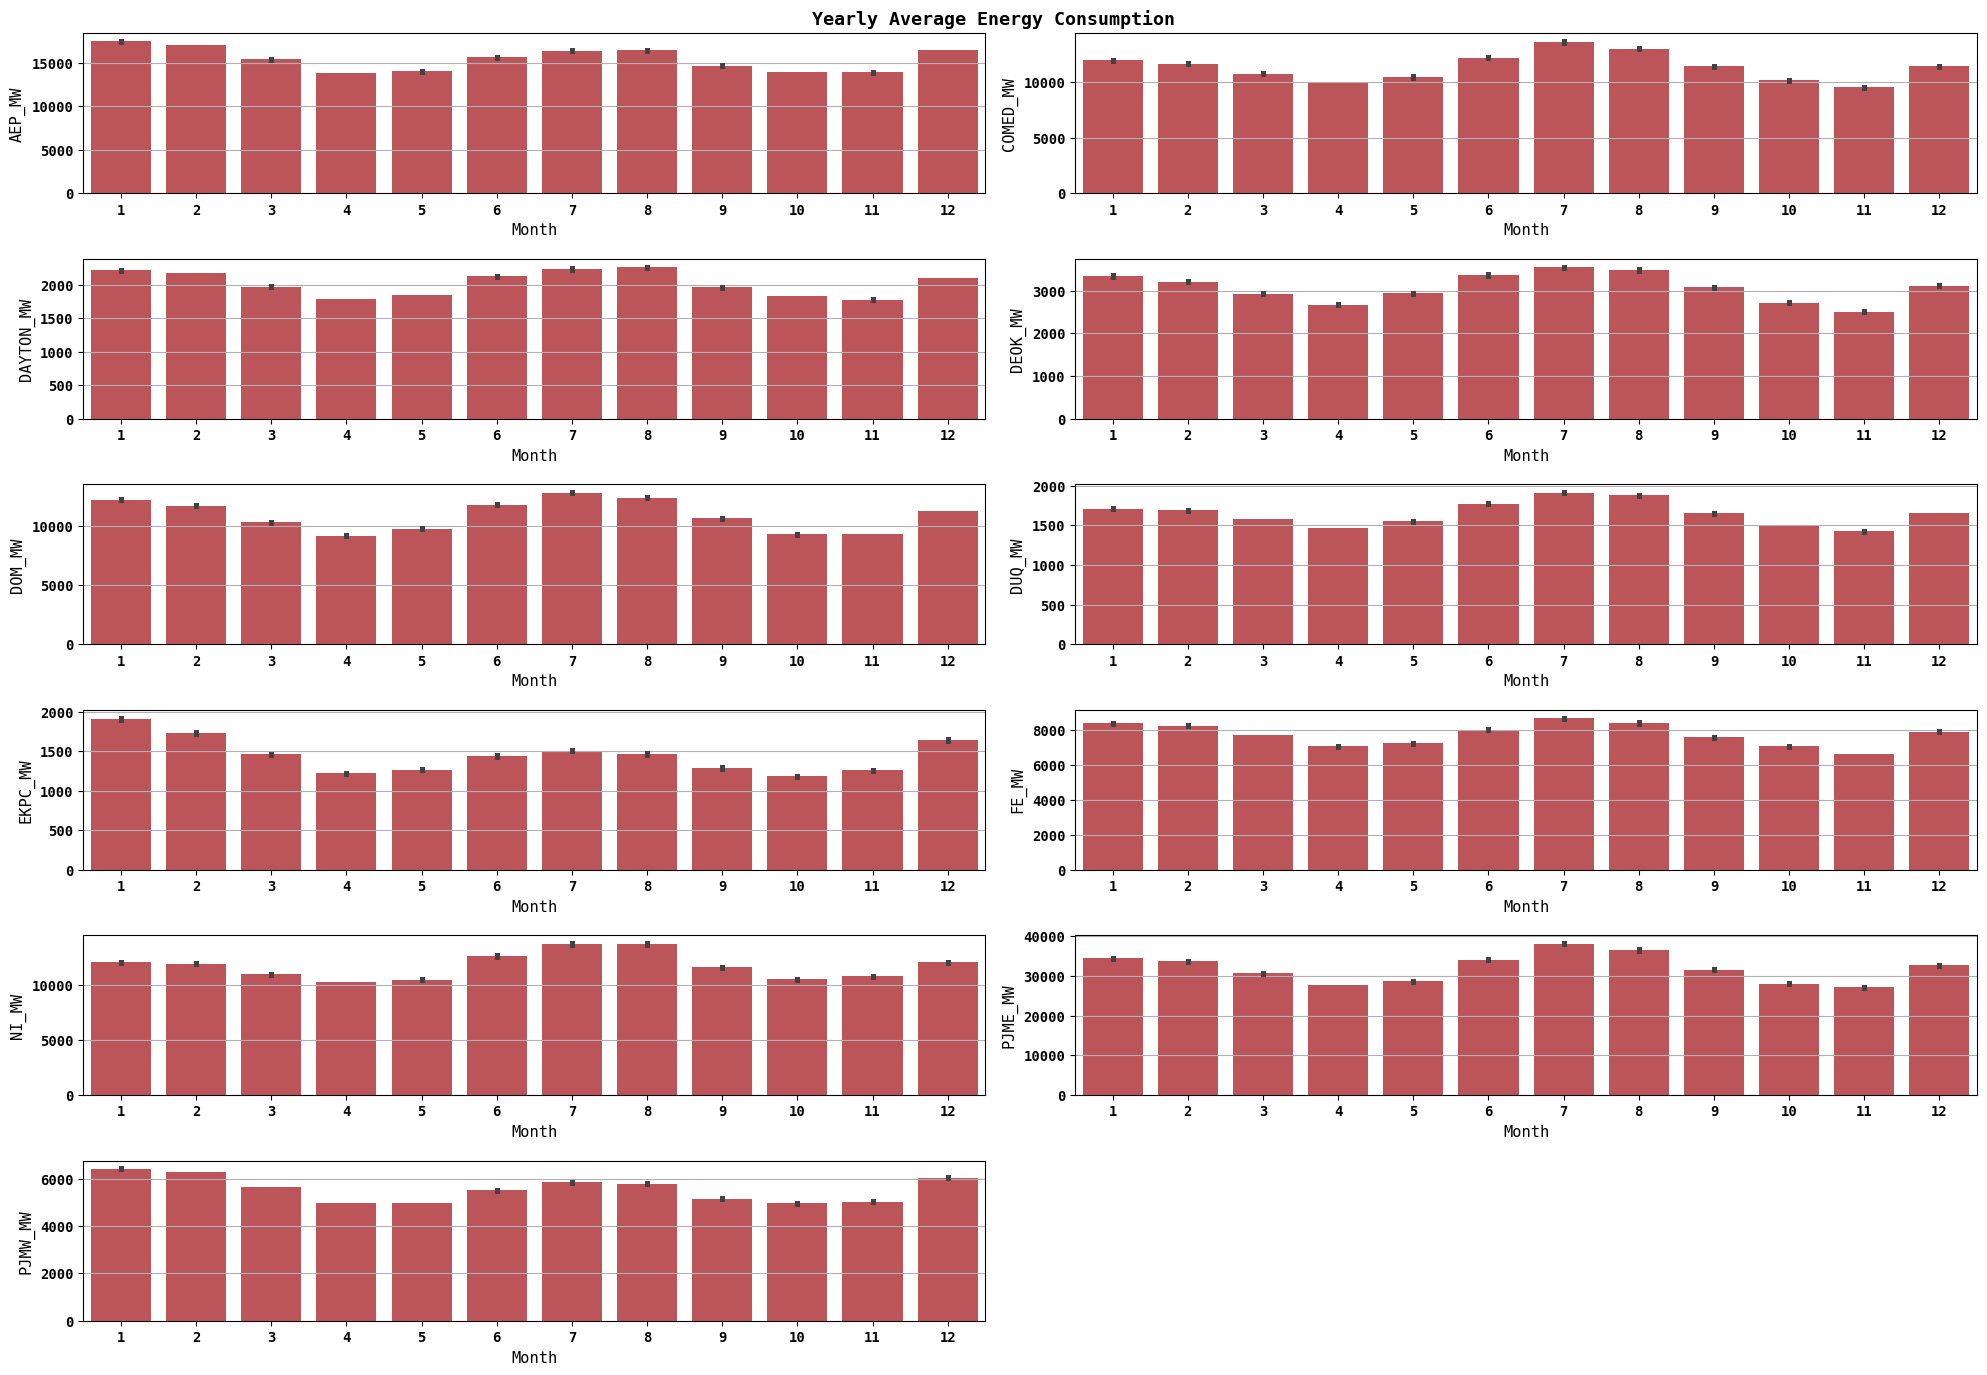

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
fig.suptitle('Yearly Average Energy Consumption', weight='bold')

# Only 11 figures are necessary, so we delete the last one
fig.delaxes(axs[5][1])

# We now use the seaborn package to plot the boxplots
for i, col in enumerate(columns):
    sns.barplot(data=df_final, x='Month', y=col, ax=axs.flatten()[i], color='#cc444b')

save_fig_png("05_energy_monthly_bar_df_seaborn")

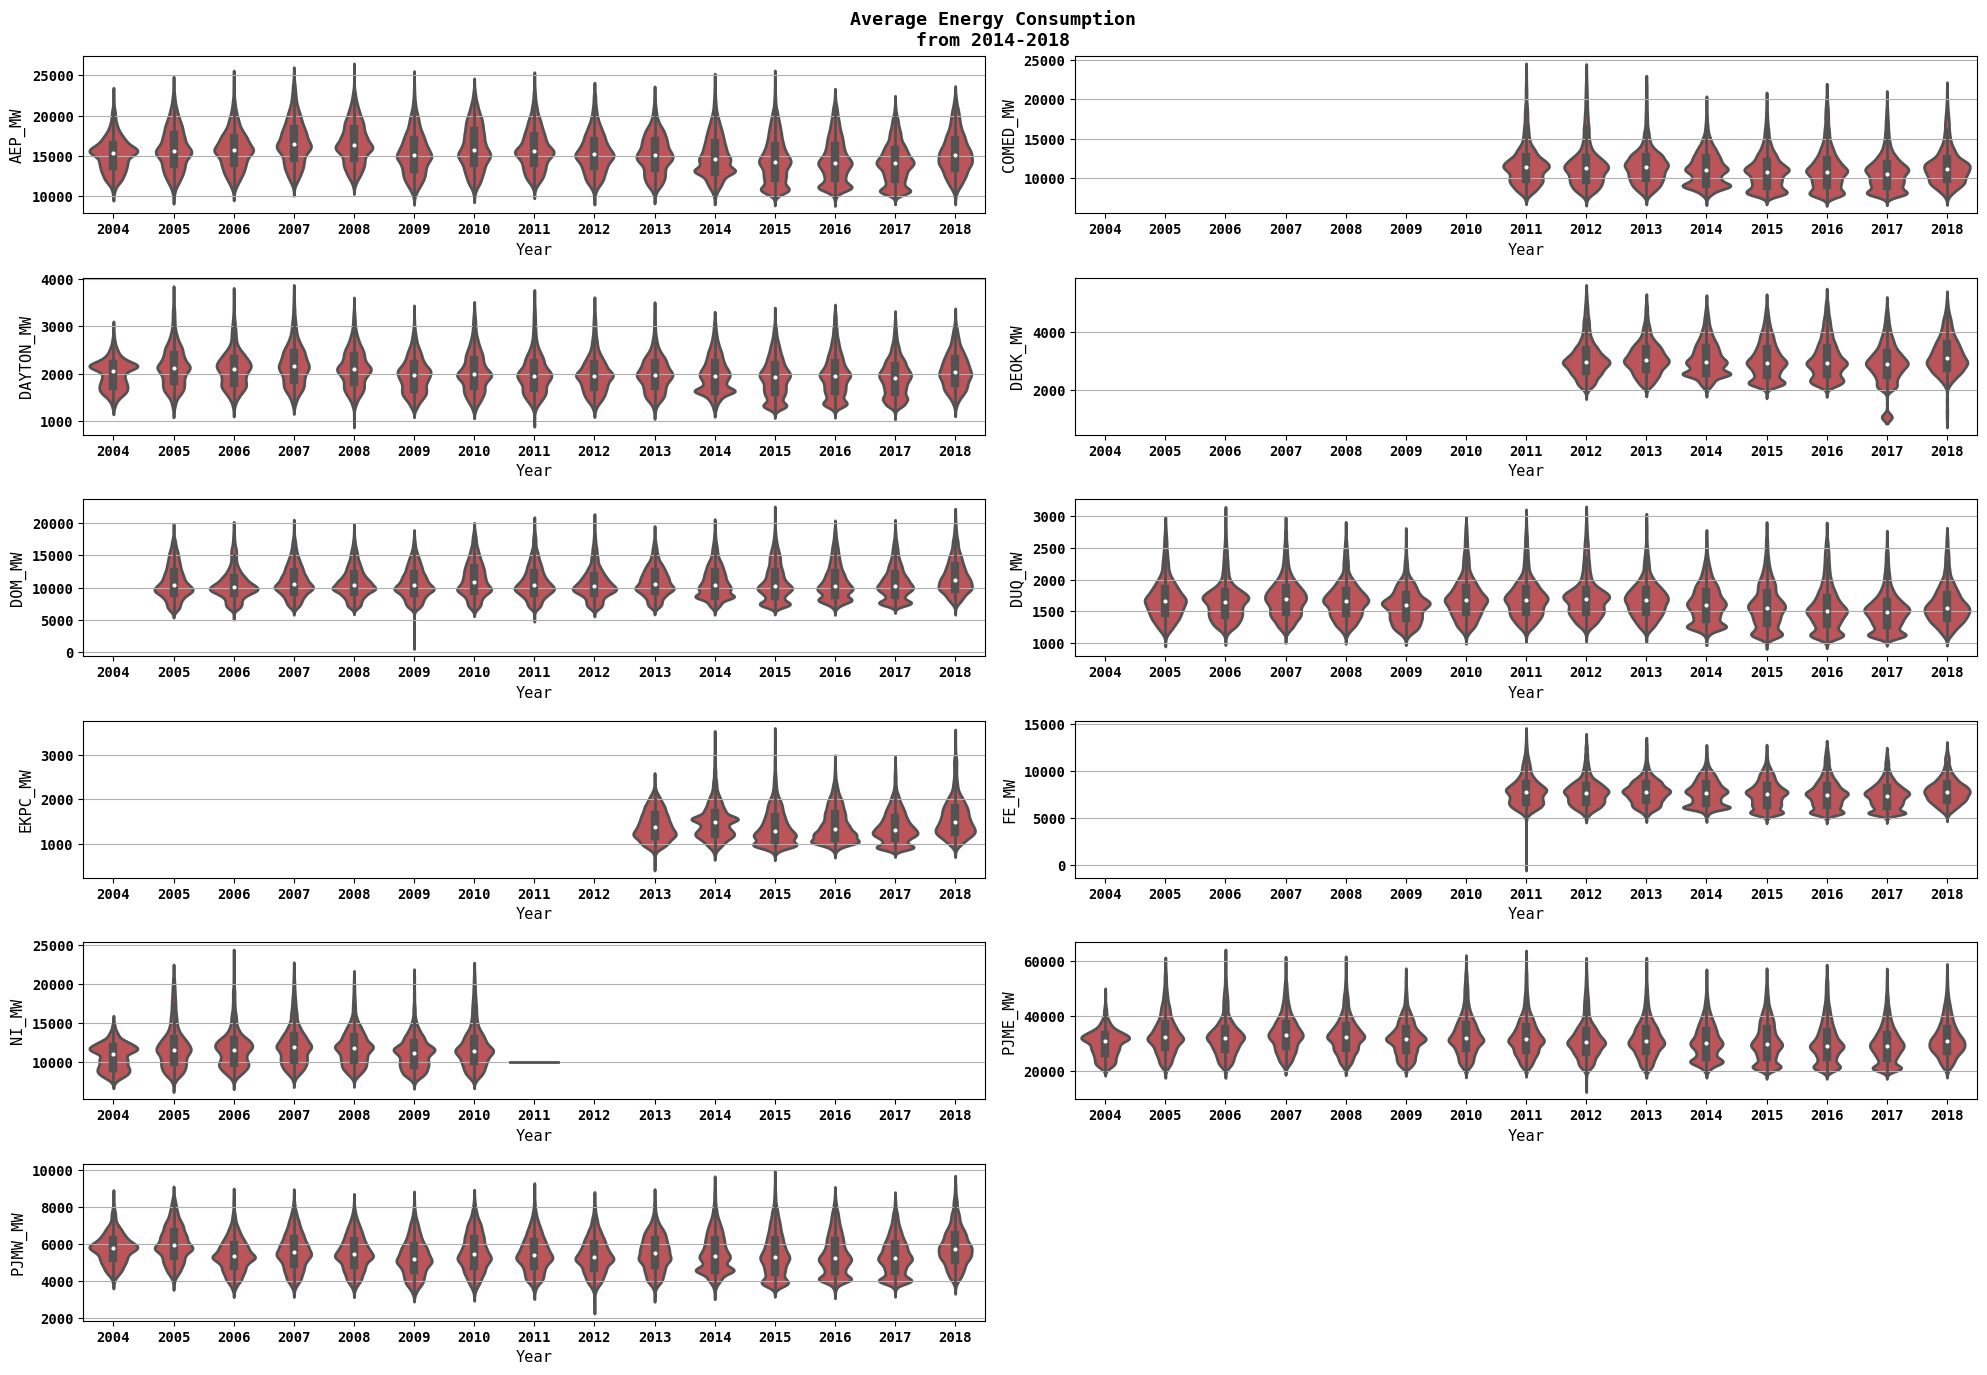

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
fig.suptitle('Average Energy Consumption\nfrom 2014-2018', weight='bold')

# Only 11 figures are necessary, so we delete the last one
fig.delaxes(axs[5][1])

# We now use the seaborn package to plot the boxplots
for i, col in enumerate(columns):
    sns.violinplot(data=df_final, x='Year', y=col, ax=axs.flatten()[i], color='#cc444b')

save_fig_png("06_energy_monthly_violin_df_seaborn")

Our data have seasonality. That's why we got approximately the same plot results for all the data in the different columns, except for missing values.

Here some interesting conclusion and insights from above investigation:
- `PJME` holds the highest energy consumption among others.
- Daily peak/highest is around 6-8 PM and the minimum is at 2 AM.
- The highest energy consumption in a year is either in the end of the year or in the middle of the year.
- Out of 11 data, 5 of them aren't complete (2004-2018).

TO-DO NEXT:
- [ ] We have to do without seaborn. To be fixed later

## A simple case to get further insights

We will now focus on the `DAYTON_MW` column of the dataset. This helps to simplify the whole process to understand in depth one part of the dataset. In addition, the treatment of the other columns should be the same.

In [ ]:
# Set color style
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

In [ ]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Data that we are going to use next (DAYTON)
df.head()

,DAYTON_MW
Datetime,
2004-10-01 01:00:00,1621.0
2004-10-01 02:00:00,1536.0
2004-10-01 03:00:00,1500.0
2004-10-01 04:00:00,1434.0
2004-10-01 05:00:00,1489.0


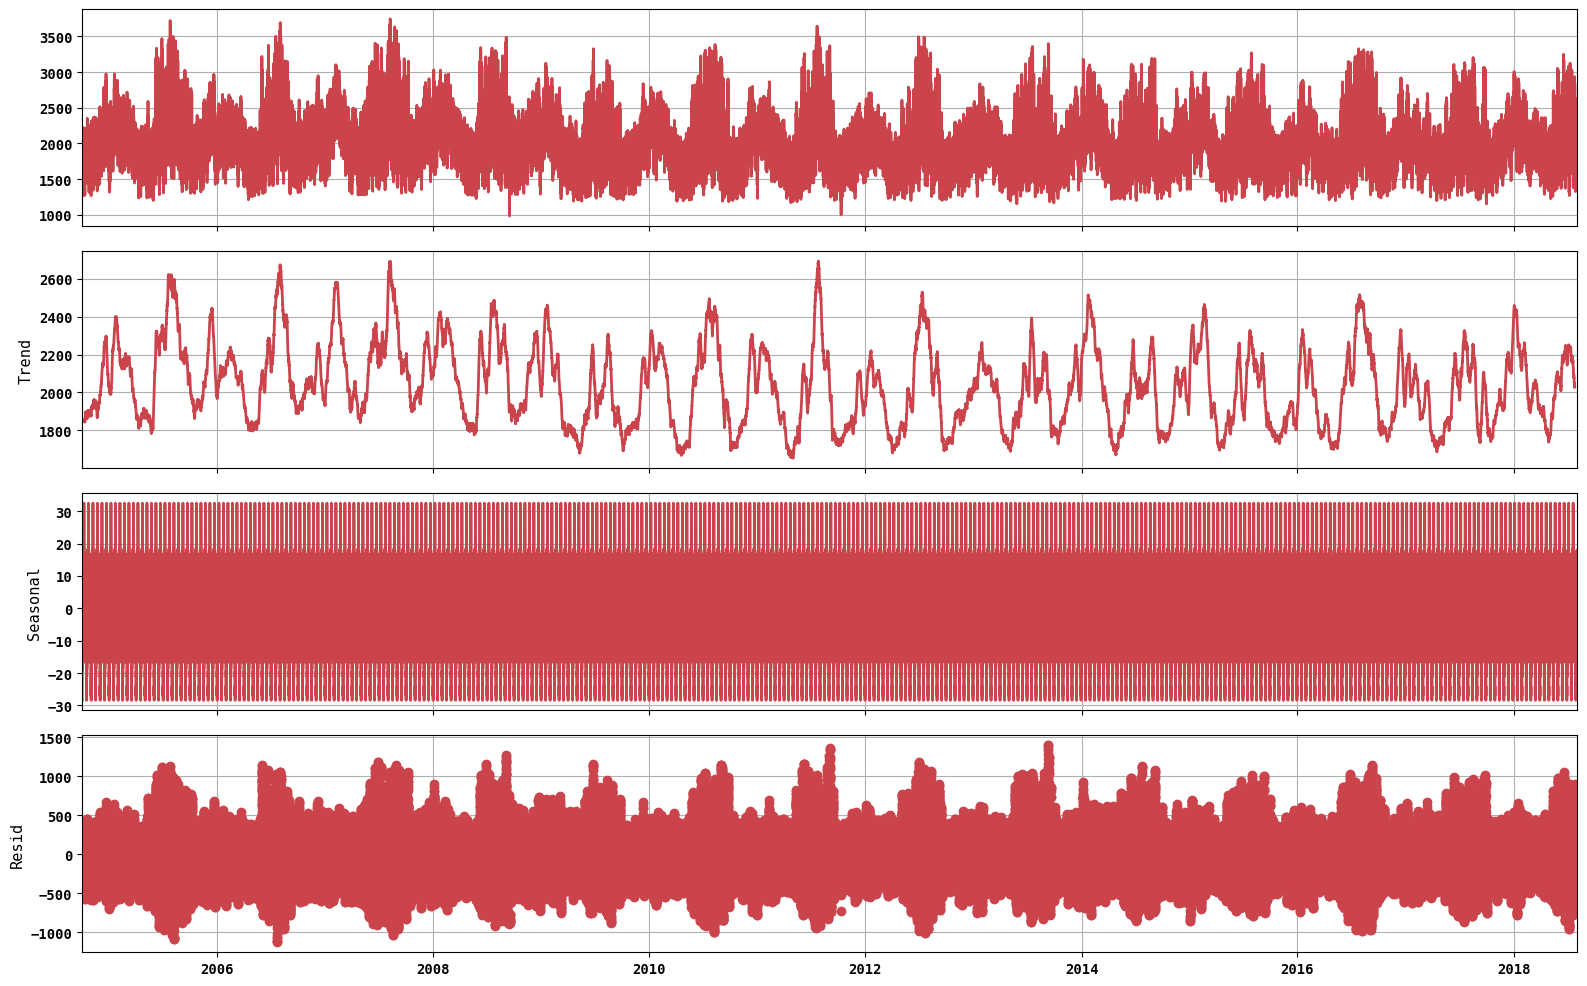

<Figure size 1600x1000 with 0 Axes>

In [ ]:
seasonal_decompose(df, period=365).plot()
plt.show()

save_fig_png("07_energy_season_df_pandas")

### The moving average

In [ ]:
# Daily consumption
ma = df.resample('D').mean()

# 3 Day example
ma['Moving Average'] = ma['DAYTON_MW'].rolling(3).mean()
ma.head()

,DAYTON_MW,Moving Average
Datetime,,
2004-10-01,1924.130435,NaN
2004-10-02,1641.583333,NaN
2004-10-03,1528.708333,1698.140700
2004-10-04,1926.541667,1698.944444
2004-10-05,1970.125000,1808.458333


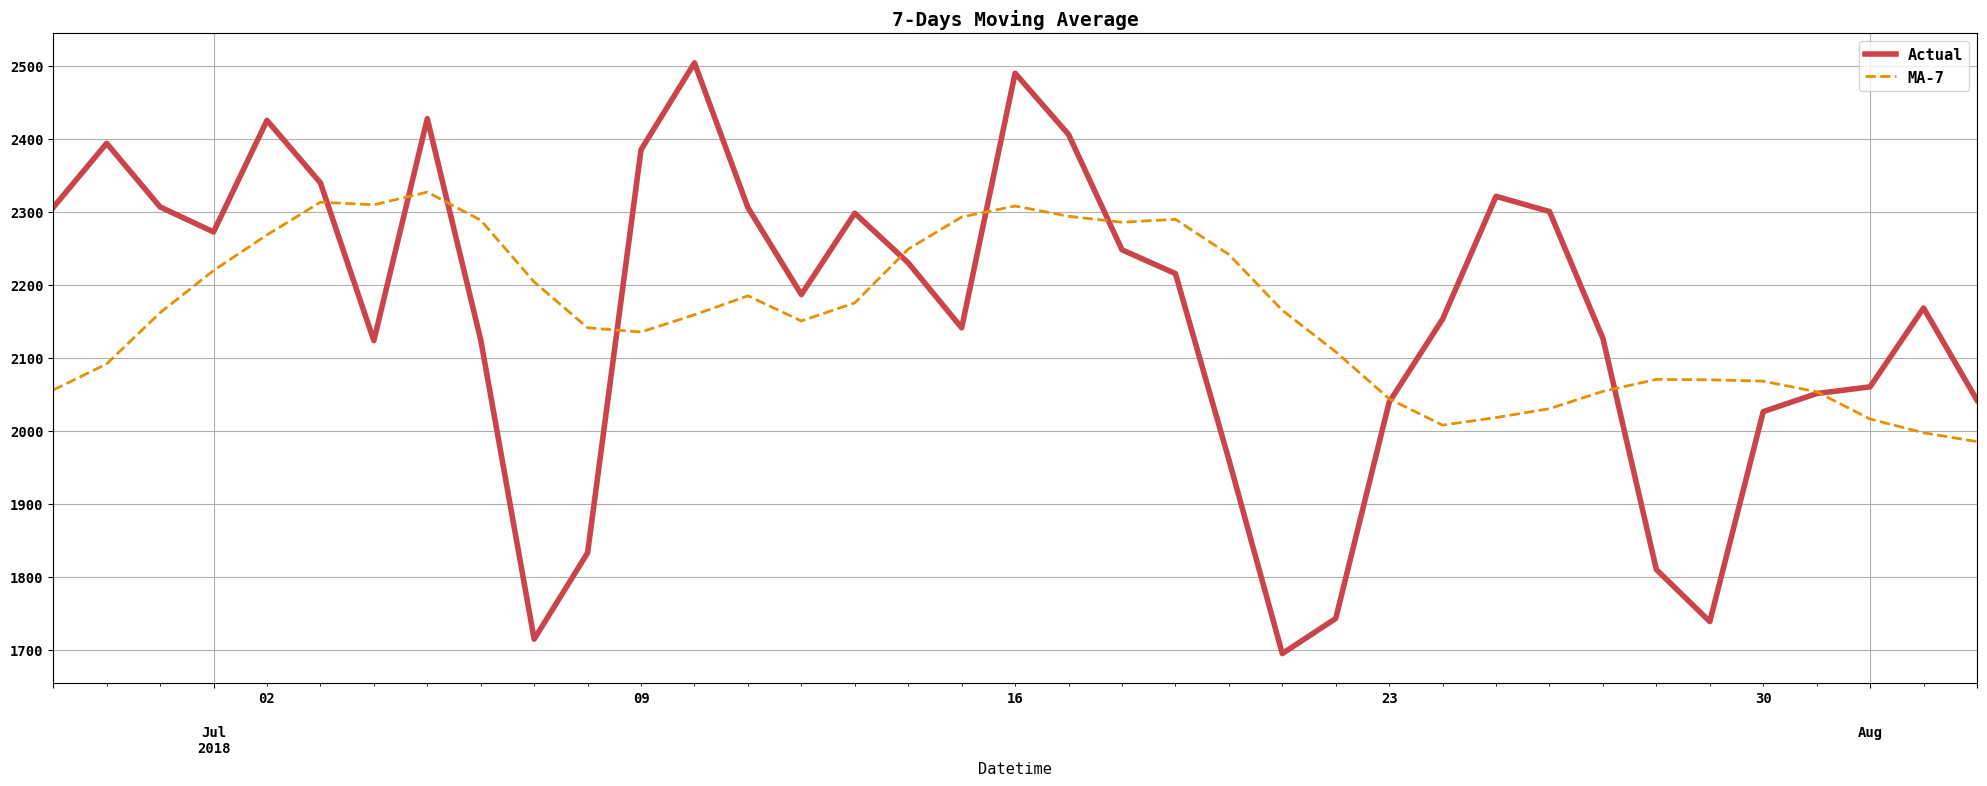

In [ ]:
def moving_average(data, window):
    data['Moving Average'] = data['DAYTON_MW'].rolling(window).mean()
    actual = data['DAYTON_MW'][-(window+30):]
    ma = data['Moving Average'][-(window+30):]
    
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('{}-Days Moving Average'.format(str(window)), weight='bold')
    plt.legend()
    
moving_average(ma, 7) # For seven days
save_fig_png("08_energy_movingavg-7d_df_pandas")

We get the same results for 30 days:

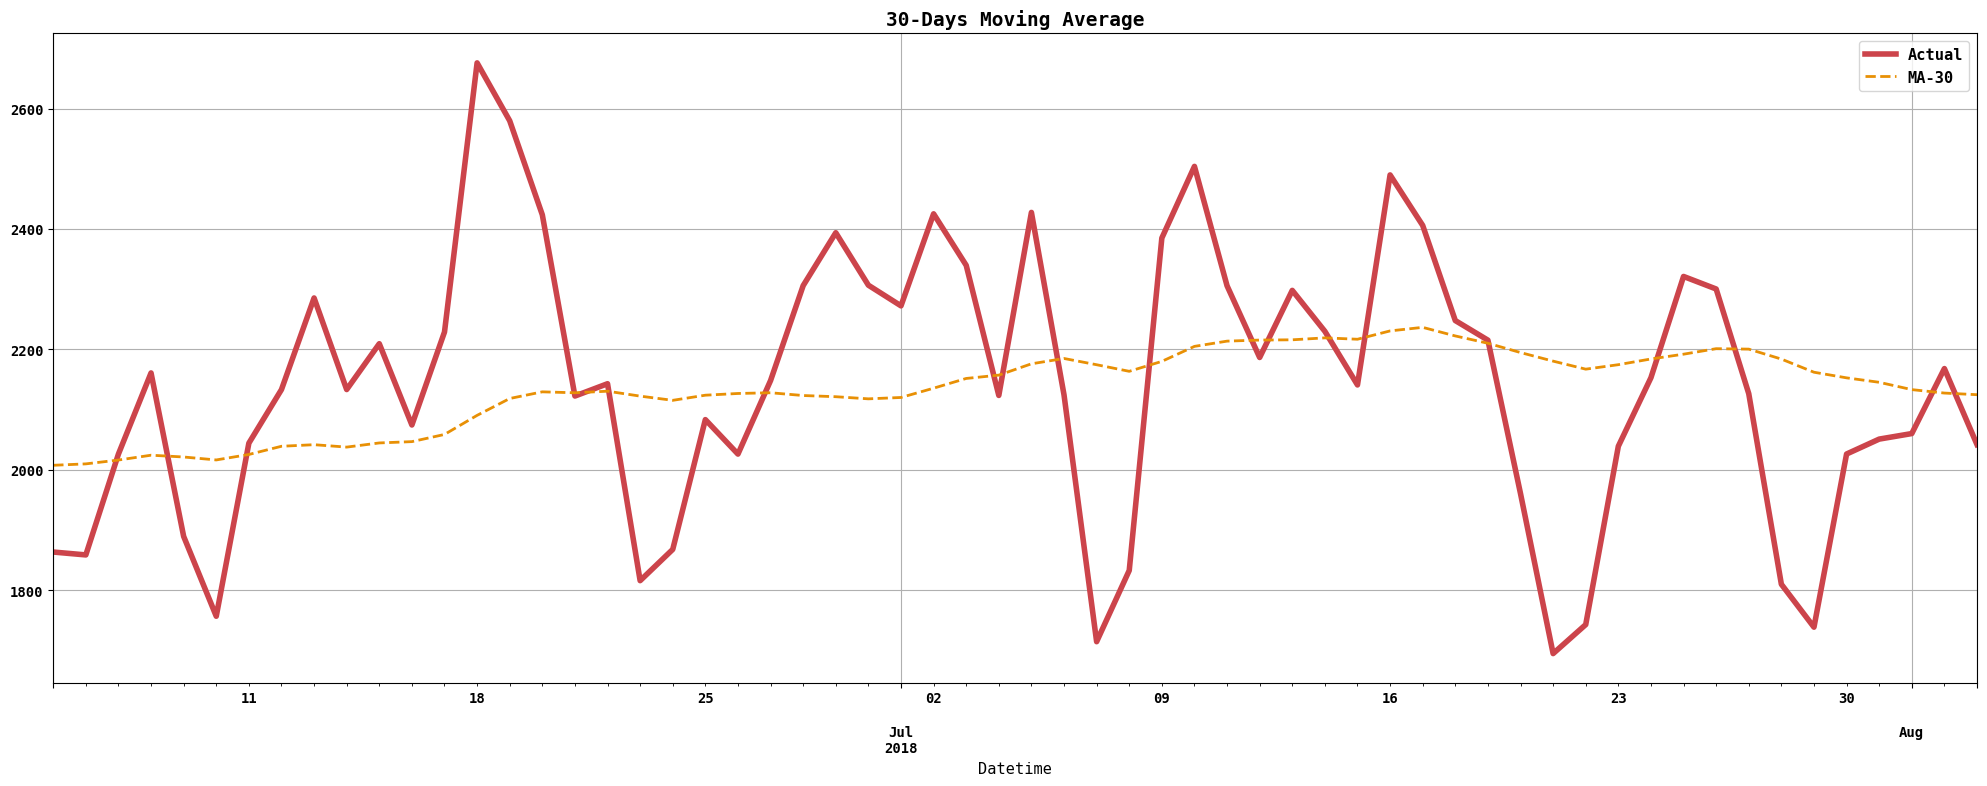

In [ ]:
moving_average(ma, 30)
save_fig_png("09_energy_movingavg-30d_df_pandas")

TO-DO NEXT:
- [ ] 

### Normalization of the data

TO-DO NEXT:
- [ ] Find a tutorial who explains very well how to do this with load curve.

### Train and test sets

In [ ]:
# Before building and training our model, let's split the data into training and testing
df_train, df_test = df[df.index < '2016-01-01'], df[df.index >= '2016-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 98595
Test:	 22680


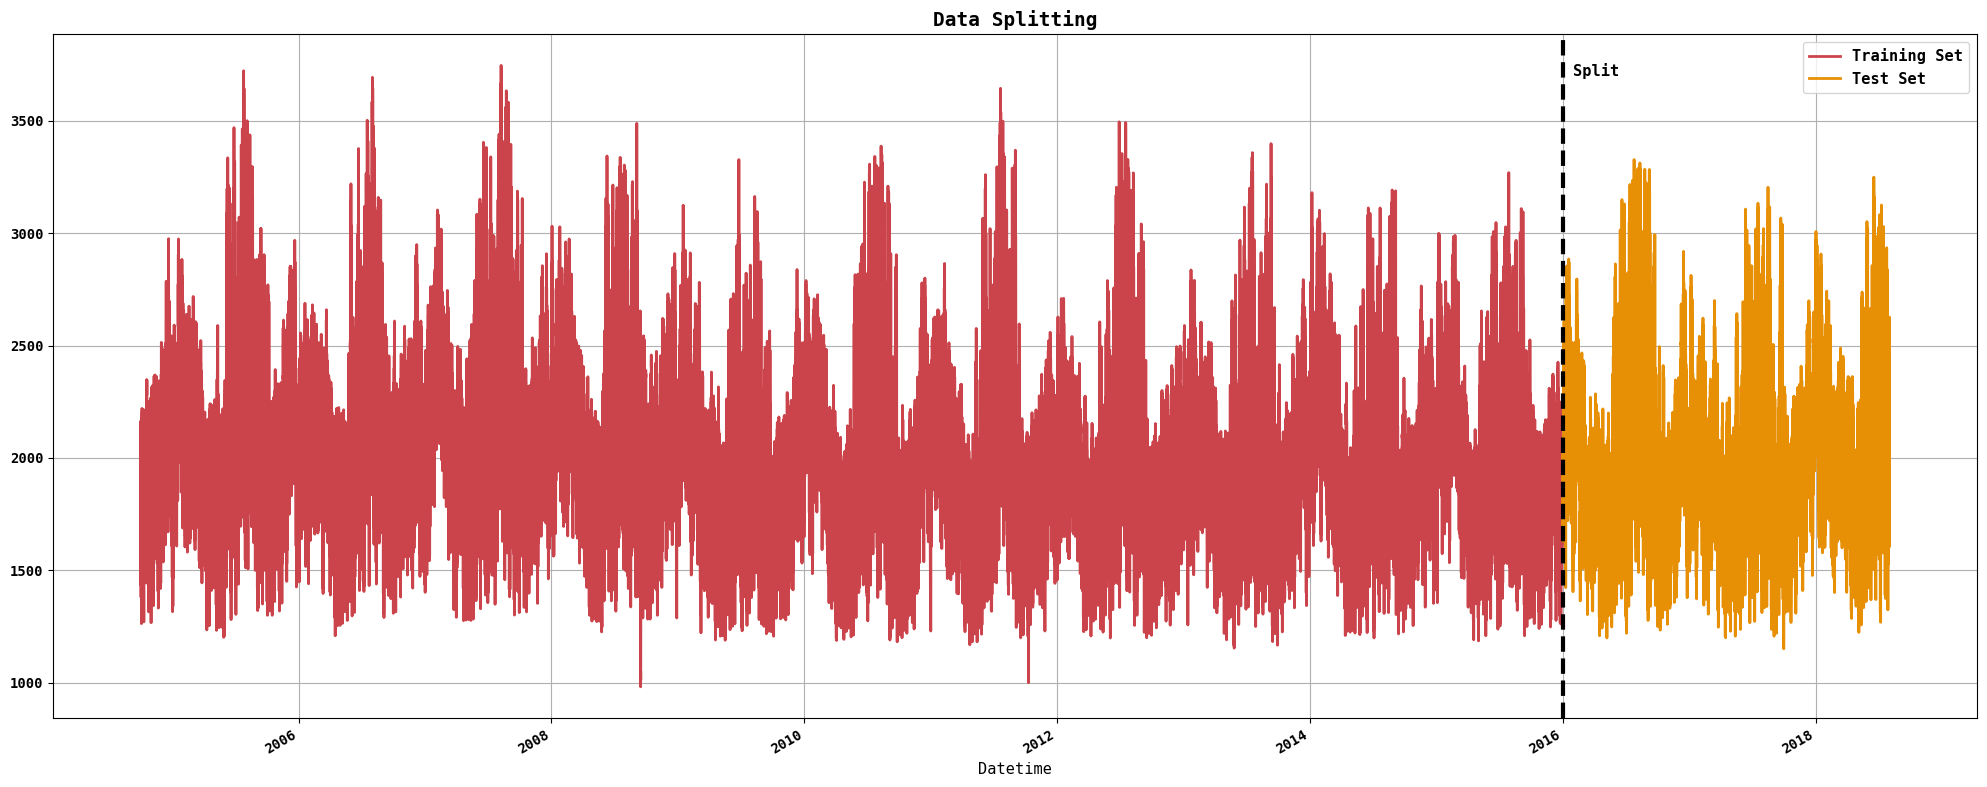

In [ ]:
plt.figure(figsize=(20,8))

df_train['DAYTON_MW'].plot(label='Training Set')
df_test['DAYTON_MW'].plot(label='Test Set')
plt.axvline('2016-01-01', color='black', ls='--', lw=3)
plt.text('2016-02-01', 3700, 'Split')#, fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold')#, fontsize=25)
plt.legend()

save_fig_png("10_energy_train-test_df_pandas")

<a id="4"></a>
# Building Models

<a id="5"></a>
## Prophet

<a id="6"></a>
## XGBoost

<a id="7"></a>
## Neural Network

<a id="8"></a>
# Conclusion